In [ ]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil
import sys
sys.path.append("..")

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from PJT_Frustration_Induced_Crystallize.main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [2]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=True
)

In [3]:
sa = StateAnalysis(model)
sa.TNum

40001

In [12]:
model.run(40000)

  0%|          | 0/40000 [00:00<?, ?it/s]

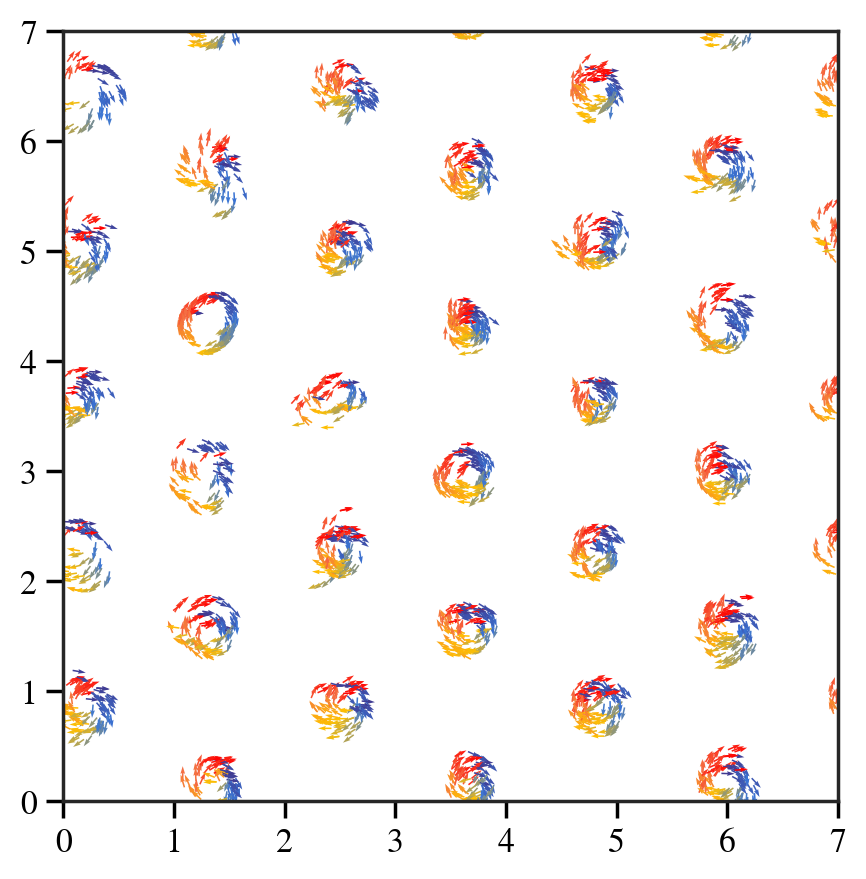

In [ ]:
# sa.plot_spatial(colorsBy="phase")
# plt.xlim(2, 3)

In [ ]:
tailDotPhaseThetas = np.array([sa.calc_dot_theta(lookIdx=i) for i in tqdm(np.arange(-100, 0, 5))])

In [10]:
shift = np.array([0., 0.])

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
centers = np.mod(centers + shift, model.boundaryLength)

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edgeLenThres = (
    model.distanceD0 + 
    2 * model.speedV / np.abs(model.freqOmega - model.strengthK * np.sin(model.phaseLagA0)).min()
) * 1.2
edges, ajdClassCenters = sa.calc_nearby_edges(edgeLenThres=edgeLenThres, classCenters=classCenters)

effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()
classEffRadius = list()
classAnalRadius = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean()
    meanNegFreq = freqOmega[freqOmega < 0].mean() if len(freqOmega[freqOmega < 0]) > 0 else 0

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()

    analRadius = model.speedV / np.abs(0 - model.strengthK * np.sin(model.phaseLagA0))
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)
    # classEffRadius.append(model.speedV / np.abs(tailDotPhaseThetas[-1, oscIdx]).min())
    classEffRadius.append(model.speedV / np.abs(meanEffFreq))
    classAnalRadius.append(analRadius)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

nearbyMeanFreqs = dict()

for i in range(len(classes)):
    selectClassFreq = classMeanFreq[i]
    nearbyMeanFreqs[selectClassFreq] = list()
    relativeDistance = sa.calc_replative_distance(classCenters[i], classCenters)
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    for j in nearbyClassIdx:
        nearbyMeanFreqs[selectClassFreq].append(classMeanFreq[j])

xFreqs = list()
yFreqs = list()

for k, v in nearbyMeanFreqs.items():
    xFreqs += [k] * len(v)
    yFreqs += v

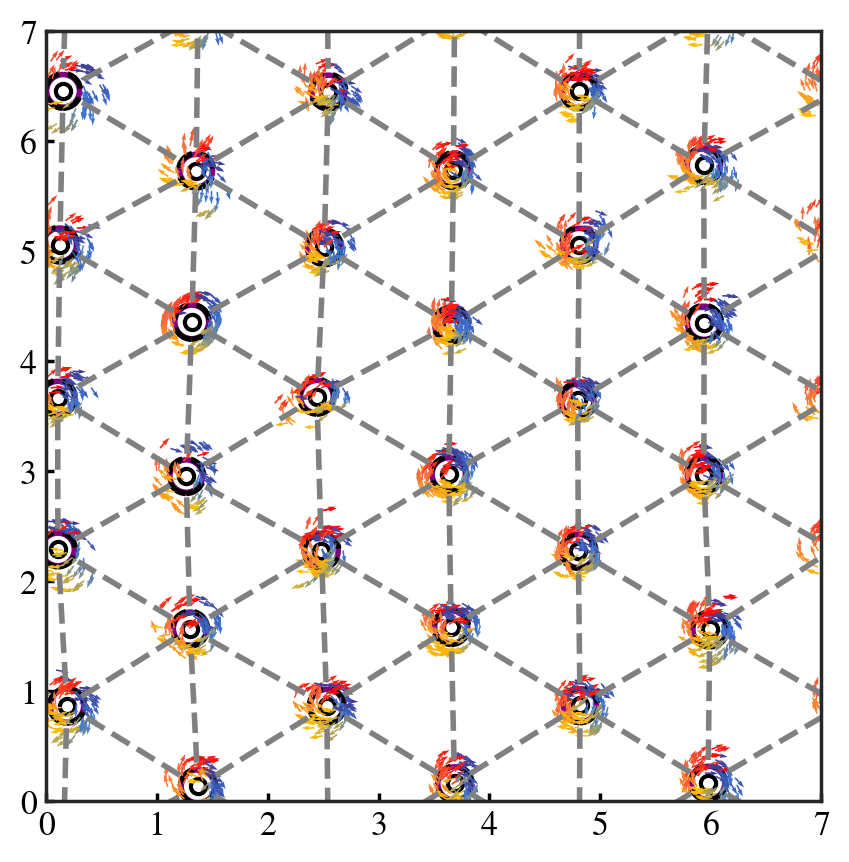

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.5 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=2, alpha=1, color="gray", ls="--")

for analRadius, effRadius, classCenter in zip(
    classAnalRadius, classEffRadius, classCenters
):
    circle = plt.Circle(
        classCenter, effRadius * 1, 
        color="purple", fill=False, lw=2, alpha=1
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        classCenter, analRadius * 1, color="black", fill=False, lw=2, alpha=1, ls="--"
    )
    ax.add_artist(circle)

sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

plt.tick_params(length=3, direction="in")

([], [])

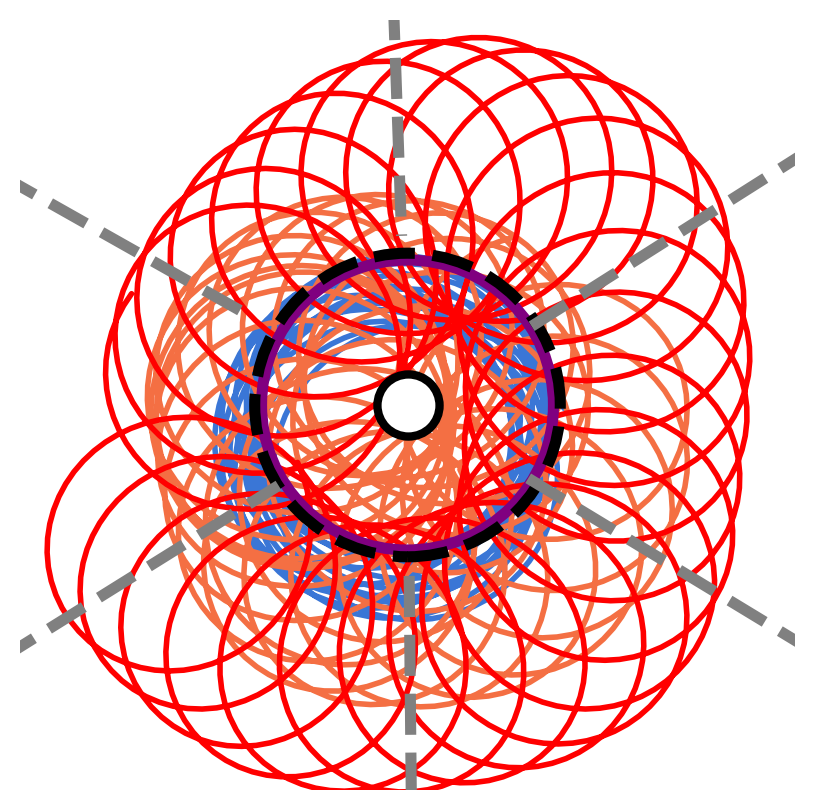

In [119]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=500, edgecolor="black", lw=3, zorder=1000
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.53 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=4, alpha=1, color="gray", ls="--", zorder=1000)

for analRadius, effRadius, classCenter in zip(
    classAnalRadius, classEffRadius, classCenters
):
    circle = plt.Circle(
        classCenter, effRadius * 1, 
        color="purple", fill=False, lw=4, alpha=1
    )
    ax.add_artist(circle)
    circle = plt.Circle(
        classCenter, analRadius * 1, color="black", fill=False, lw=4, alpha=1, ls="--"
    )
    ax.add_artist(circle)

# sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

focusClassIdx = 4

focusParticleIdx = classes[focusClassIdx]
positionX = sa.totalPositionX[-1][focusParticleIdx] + shift
phaseTheta = sa.totalPhaseTheta[-1][focusParticleIdx]
colors = [cmap(i) for i in
    np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
]
# ax.quiver(
#     positionX[:, 0], positionX[:, 1],
#     np.cos(phaseTheta), np.sin(phaseTheta), 
#     # scale_units='inches', scale=15.0, width=0.002,
#     color=colors
# )
timeCounts = [1000, 1600, 1500]
trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
for i, singleSelectIdx in enumerate([7, 3, 1]):
    ax.plot(
        sa.totalPositionX[-timeCounts[i]:, focusParticleIdx, 0][:, singleSelectIdx],
        sa.totalPositionX[-timeCounts[i]:, focusParticleIdx, 1][:, singleSelectIdx],
        color=trajectoryColors[i], alpha=1, lw=2, zorder=0
    )


focusCenter = classCenters[focusClassIdx]
halfWidth = 0.4

plt.xlim(focusCenter[0] - halfWidth, focusCenter[0] + halfWidth)
plt.ylim(focusCenter[1] - halfWidth, focusCenter[1] + halfWidth)

plt.tick_params(length=3, direction="in")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.xticks([])
plt.yticks([])

In [36]:
sa.totalPositionX[-1000:, focusParticleIdx, 0][:, 0]

array([2.54502297, 2.55345006, 2.56058284, 2.56634728, 2.57068356,
       2.57354668, 2.57490711, 2.5747503 , 2.57307859, 2.56992308,
       2.5653435 , 2.55939621, 2.55214085, 2.54364675, 2.53399467,
       2.52328884, 2.511628  , 2.49911932, 2.48587743, 2.47202345,
       2.45768387, 2.4429896 , 2.42807479, 2.4130757 , 2.39812945,
       2.38337284, 2.36894109, 2.3549666 , 2.34157776, 2.3289139 ,
       2.31712043, 2.30634484, 2.2967215 , 2.28837528, 2.28141908,
       2.27595077, 2.27204345, 2.26974178, 2.26905265, 2.26993222,
       2.27235862, 2.27632349, 2.28178304, 2.28868653, 2.29694971,
       2.30648471, 2.31719553, 2.32896903, 2.34166763, 2.35515166,
       2.36926609, 2.38383605, 2.39869862, 2.41369141, 2.42865221,
       2.44343098, 2.45788437, 2.47186751, 2.48524609, 2.49789594,
       2.5097097 , 2.52057387, 2.53038638, 2.53905496, 2.5464981 ,
       2.55263537, 2.55739249, 2.56072296, 2.56259465, 2.56298988,
       2.56192042, 2.55939694, 2.5554563 , 2.55013578, 2.54348

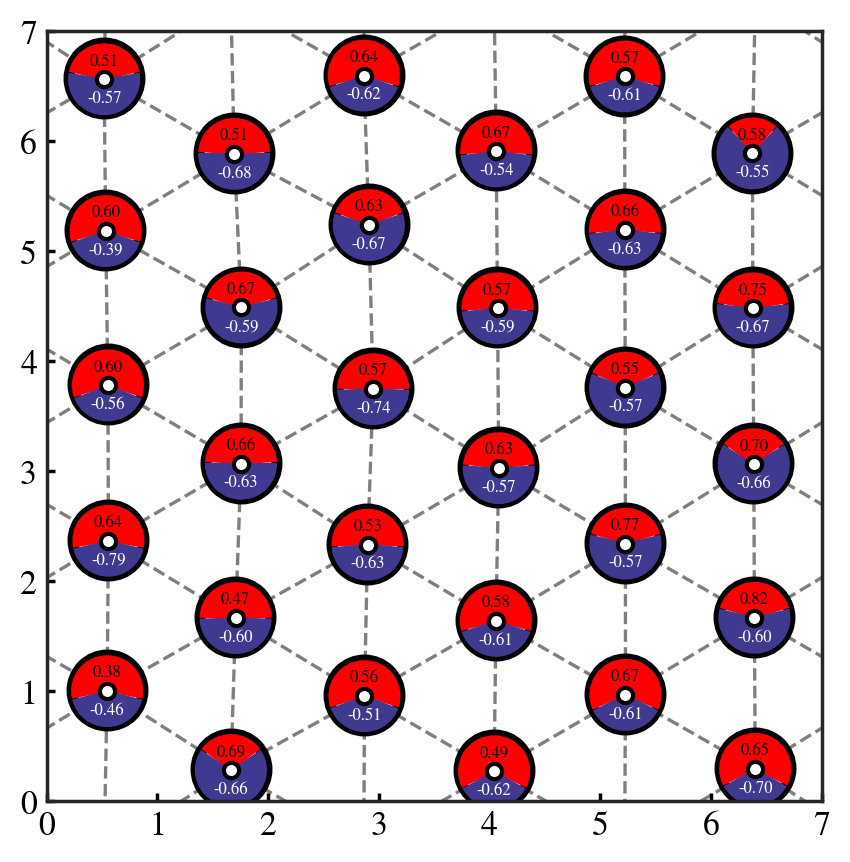

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0] - 0.003, classCenters[:, 1] + 0.008, 
    facecolor="white", cmap=cmap, s=650, edgecolor="black", lw=4
)
plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    facecolor="white", cmap=cmap, s=30, edgecolor="black", lw=1.5, zorder=10
)

for edge in periodicEdges[:]:
    plt.plot(adjClassCenters[edge, 0], adjClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)

width = 0.4
height = 0.4
linewidth = 10
textLength = 0.17
posTextAngle = np.pi * 0.5
negTextAngle = np.pi * 1.5

for classIdx in range(len(classes)):
    posPerent = classPosPerent[classIdx]
    negPerent = classNegPerent[classIdx]
    meanPosFreq = classMeanPosFreq[classIdx]
    meanNegFreq = classMeanNegFreq[classIdx]
    classCenter = classCenters[classIdx]
    angle = 90 - 360 * posPerent / 2
    ax.add_patch(patches.Arc(xy=classCenter, width=width, height=height,  
                             theta1=angle, theta2=angle + 360 * posPerent, 
                            #  color=cmap((meanPosFreq - min(classMeanPosFreq)) / (max(classMeanPosFreq) - min(classMeanPosFreq)) / 2 + 0.5), 
                             color="red",
                             alpha=1, lw=linewidth))
    ax.add_patch(patches.Arc(xy=classCenter, width=width, height=height, 
                             theta1=angle + 360 * posPerent, theta2=angle + 360, 
                            #  color=cmap((meanNegFreq - min(classMeanNegFreq)) / (max(classMeanNegFreq) - min(classMeanNegFreq)) / 2), 
                             color="#403990",
                             alpha=1, lw=linewidth))
    ax.text(classCenter[0] + textLength * np.cos(posTextAngle),
            classCenter[1] + textLength * np.sin(posTextAngle),
            f"{meanPosFreq:.2f}", ha="center", va="center", fontsize=6, color="black")
    ax.text(classCenter[0] + textLength * np.cos(negTextAngle),
            classCenter[1] + textLength * np.sin(negTextAngle),
            f"{meanNegFreq:.2f}", ha="center", va="center", fontsize=6, color="white")

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")

plt.savefig(f"{LOCAL_FIG_PATH}/statistics.pdf", bbox_inches="tight")

In [23]:
edgeLenThres = 1.5

nearbyMeanFreqs = dict()

for i in range(len(classes)):
    selectClassFreq = classMeanFreq[i]
    nearbyMeanFreqs[selectClassFreq] = list()
    relativeDistance = sa.calc_replative_distance(classCenters[i], classCenters)
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    for j in nearbyClassIdx:
        nearbyMeanFreqs[selectClassFreq].append(classMeanFreq[j])

xFreqs = list()
yFreqs = list()

for k, v in nearbyMeanFreqs.items():
    xFreqs += [k] * len(v)
    yFreqs += v

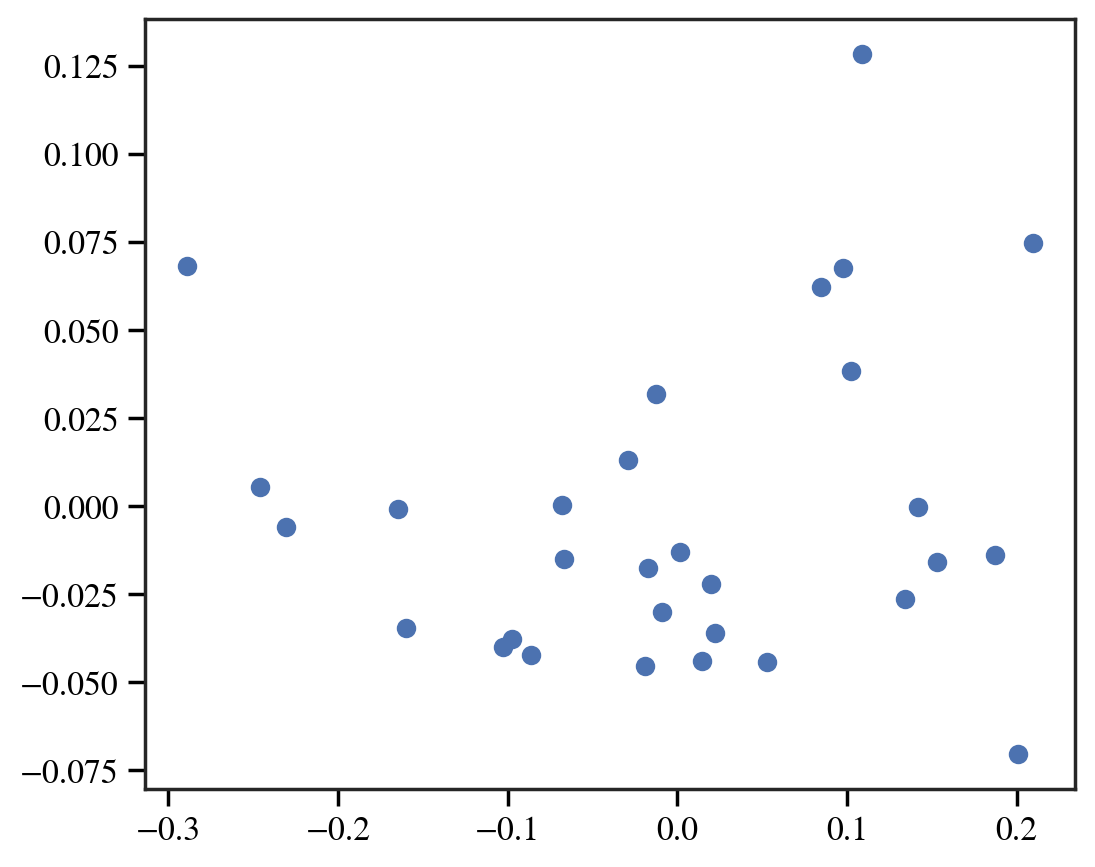

In [24]:
meanNearByFreq = [np.mean(v) for v in nearbyMeanFreqs.values()]
plt.scatter(nearbyMeanFreqs.keys(), meanNearByFreq)

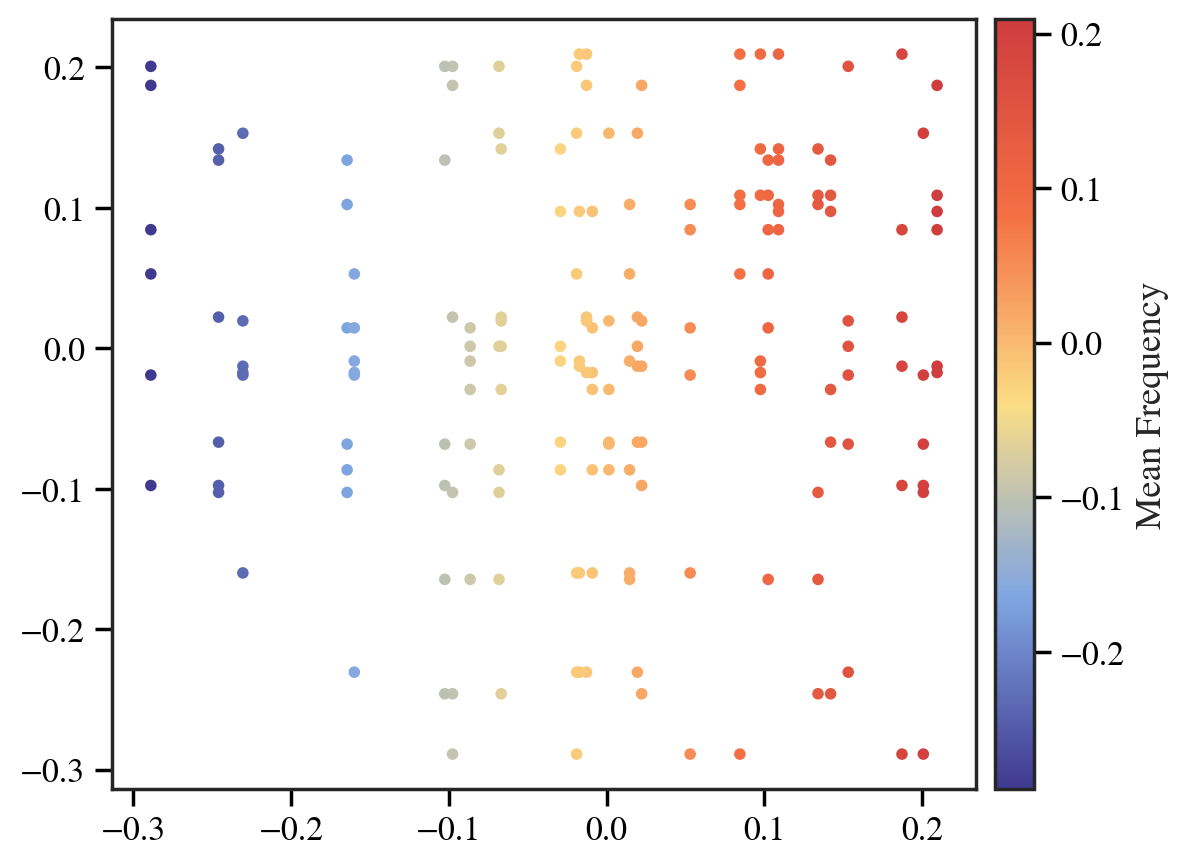

In [25]:
sc = plt.scatter(xFreqs, yFreqs, s=10, c=xFreqs, cmap=cmap)
plt.colorbar(sc, label="Mean Frequency", fraction=0.05, pad=0.02)

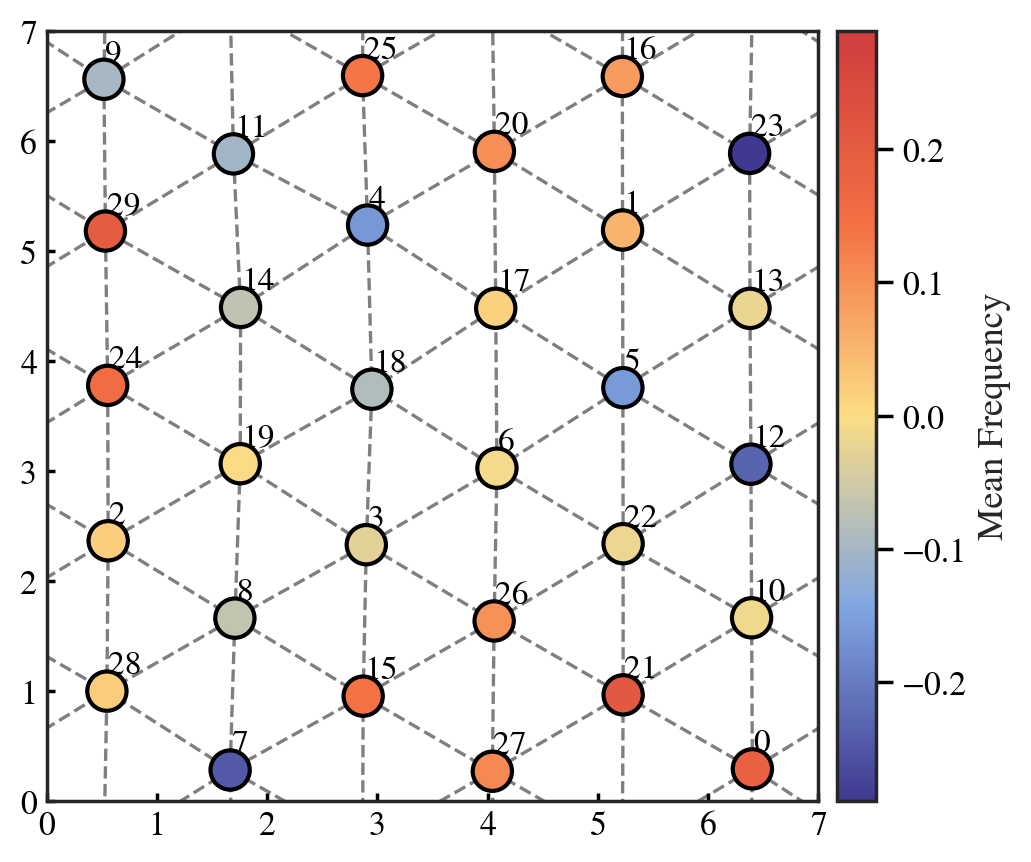

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

bound = np.abs(classMeanFreq).max()

sc = plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    c=classMeanFreq, s=200, edgecolor="black", lw=1.5, zorder=10,
    cmap=cmap, vmin=-bound, vmax=bound
)
plt.colorbar(sc, label="Mean Frequency", orientation="vertical", pad=0.02)

for edge in periodicEdges[:]:
    plt.plot(adjClassCenters[edge, 0], adjClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)
    
for i, classCenter in enumerate(classCenters):
    plt.text(
        classCenter[0] + 0.01, classCenter[1] + 0.1, 
        f"{i}", ha="left", va="bottom", fontsize=12, color="black"
    )

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")
plt.savefig(f"{LOCAL_FIG_PATH}/mean_freq.pdf", bbox_inches="tight")

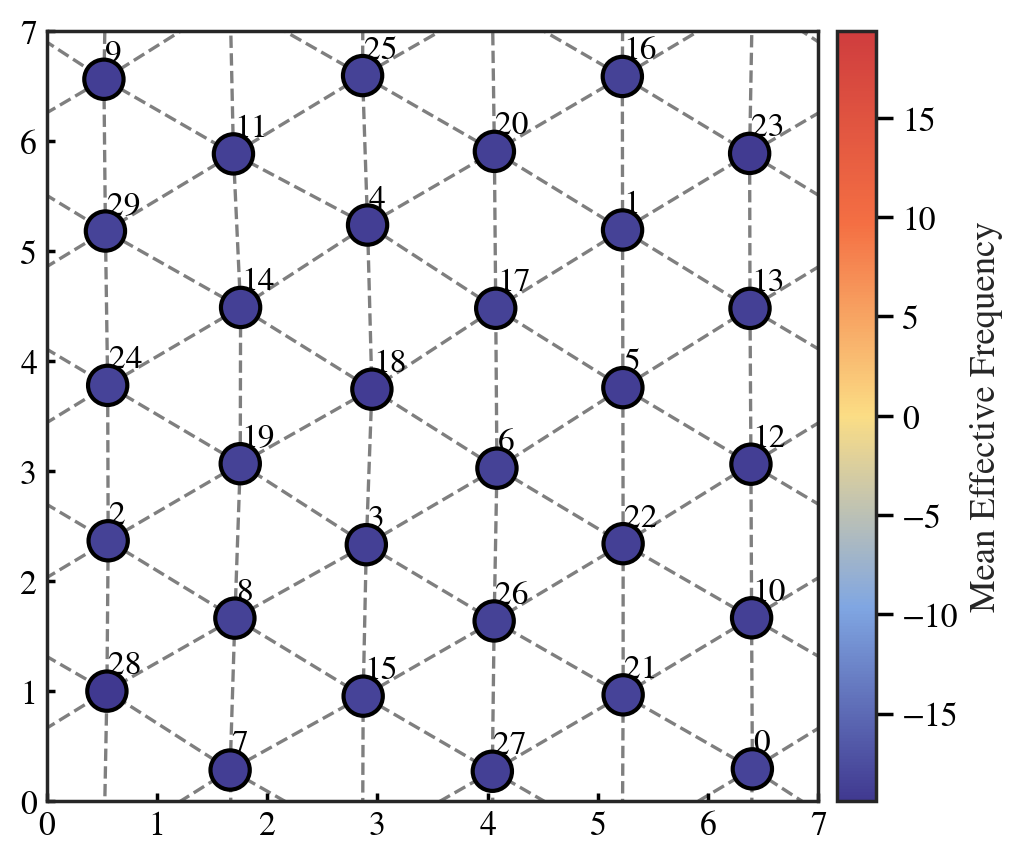

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

bounds = np.abs(classMeanEffFreq).max()

sc = plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    c=classMeanEffFreq, s=200, edgecolor="black", lw=1.5, zorder=10,
    cmap=cmap, vmin=-bounds, vmax=bounds
)
# sc = plt.scatter(-np.ones(len(classes)*2), -np.ones(len(classes)*2), cmap=cmap,
#                  c=np.concatenate([classMeanEffFreq, -np.array(classMeanEffFreq)]))
plt.colorbar(sc, label="Mean Effective Frequency", orientation="vertical", pad=0.02)

for edge in periodicEdges[:]:
    plt.plot(adjClassCenters[edge, 0], adjClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)
    
for i, classCenter in enumerate(classCenters):
    plt.text(
        classCenter[0] + 0.01, classCenter[1] + 0.1, 
        f"{i}", ha="left", va="bottom", fontsize=12, color="black"
    )

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")
plt.savefig(f"{LOCAL_FIG_PATH}/mean_eff_freq.pdf", bbox_inches="tight")

In [27]:
edgeLenThres = 1.5

highPosClassIdx = np.arange(len(classes))[classPosPerent > 0.6]
nearbyPosPerent = list()
nearbyNegPerent = list()

for classIdx in highPosClassIdx:
    relativeDistance = sa.calc_replative_distance(
        position1=classCenters[classIdx], position2=classCenters
    )
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    nearbyNegPerent += classNegPerent[nearbyClassIdx].tolist()
    nearbyPosPerent += classPosPerent[nearbyClassIdx].tolist()

print("Nearby positive parent percentage:", np.mean(nearbyPosPerent))
print("Nearby negative parent percentage:", np.mean(nearbyNegPerent))

highNegClassIdx = np.arange(len(classes))[classNegPerent > 0.6]
nearbyPosPerent = list()
nearbyNegPerent = list()

for classIdx in highNegClassIdx:
    relativeDistance = sa.calc_replative_distance(
        position1=classCenters[classIdx], position2=classCenters
    )
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    nearbyNegPerent += classNegPerent[nearbyClassIdx].tolist()
    nearbyPosPerent += classPosPerent[nearbyClassIdx].tolist()

print("Nearby positive parent percentage:", np.mean(nearbyPosPerent))
print("Nearby negative parent percentage:", np.mean(nearbyNegPerent))

Nearby positive parent percentage: 0.5261942751860011
Nearby negative parent percentage: 0.4738057248139988
Nearby positive parent percentage: 0.5022634880701256
Nearby negative parent percentage: 0.4977365119298745


In [5]:
edges = sa.calc_nearby_edges(edgeLenThres=1.5, 
                             classCenters=classCenters,
                             relativeDistance=True)

distances = pd.DataFrame(columns=["centerDis", "radius1", "radius2"])

for edge in edges:
    distances = distances.append({
        "centerDis": sa.calc_replative_distance(
            classCenters[edge[0]], classCenters[edge[1]]
        ),
        "radius1": classMaxRadius[edge[0]],
        "radius2": classMaxRadius[edge[1]]
    }, ignore_index=True)

distances = (
    distances.sort_values(by="centerDis")
    .reset_index(drop=True)
)

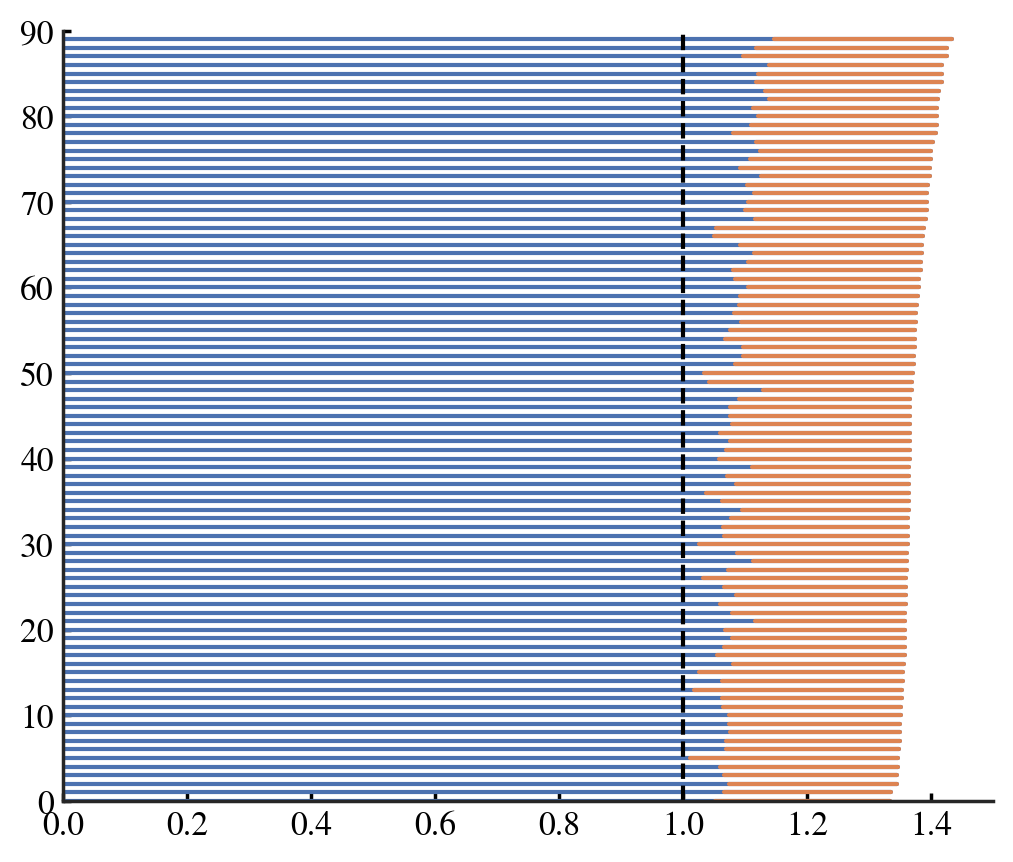

In [10]:
for idx, row in distances.iterrows():
    plt.plot(
        [0, row["centerDis"]], [idx, idx],
        markersize=5, color="C0", lw=1.5
    )
    plt.plot(
        [row["centerDis"] - max(row["radius1"], row["radius2"]), row["centerDis"]], [idx, idx],
        markersize=5, color="C1", lw=1.5
    )

plt.axvline(x=1, color="black", lw=1.5, linestyle="--")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlim(0, 1.5)
plt.ylim(0, len(distances))
plt.tick_params(length=3, direction="in")

In [ ]:
classCoordinate = pd.DataFrame(
    classCenters,
    columns=["x", "y"]
).round()
drawnClasses = classCoordinate.sort_values(by=["y", "x"]).index

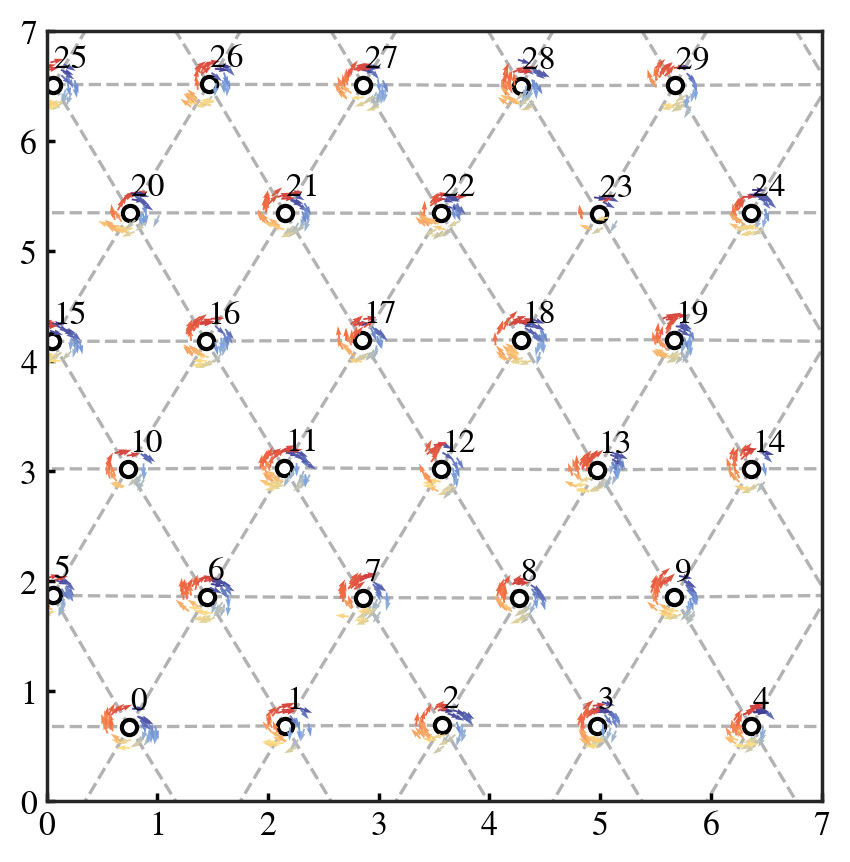

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

for edge in periodicEdges[:]:
    plt.plot(adjClassCenters[edge, 0], adjClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.3, linestyle="--", zorder=0)

plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    facecolor="white", cmap=cmap, s=30, edgecolor="black", lw=1.5
)

for i, drawnClass in enumerate(drawnClasses):
    plt.text(
        classCenters[drawnClass][0] + 0.01, 
        classCenters[drawnClass][1] + 0.1, 
        f"{i}", ha="left", va="bottom", fontsize=12, color="black"
    )

sa.plot_spatial(ax=ax, colorsBy="phase")

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")


In [67]:
sortedOscIdxs = np.concatenate([classes[c] for c in drawnClasses])
sortedPos = sa.totalPositionX[-1, sortedOscIdxs]
relativeDistance = sa.calc_replative_distance(
    sortedPos, sortedPos[:, np.newaxis]
)
A = (relativeDistance <= sa.model.distanceD0).astype(np.int32)

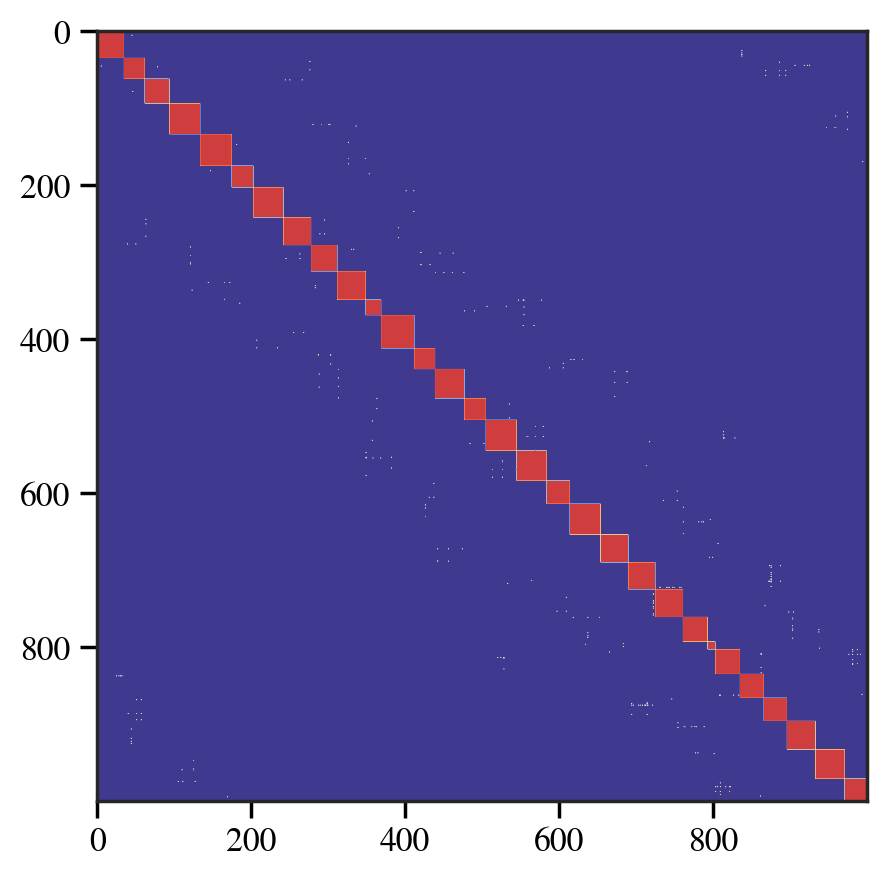

In [ ]:
plt.imshow(A, cmap=cmap)

In [ ]:
model = PhaseLagPatternFormation1D(strengthK=20, distanceD0=1, phaseLagA0=0.6*np.pi, 
                                  dt=0.001,
                                  tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
                                  randomSeed=9, overWrite=True)
model.run(80000)

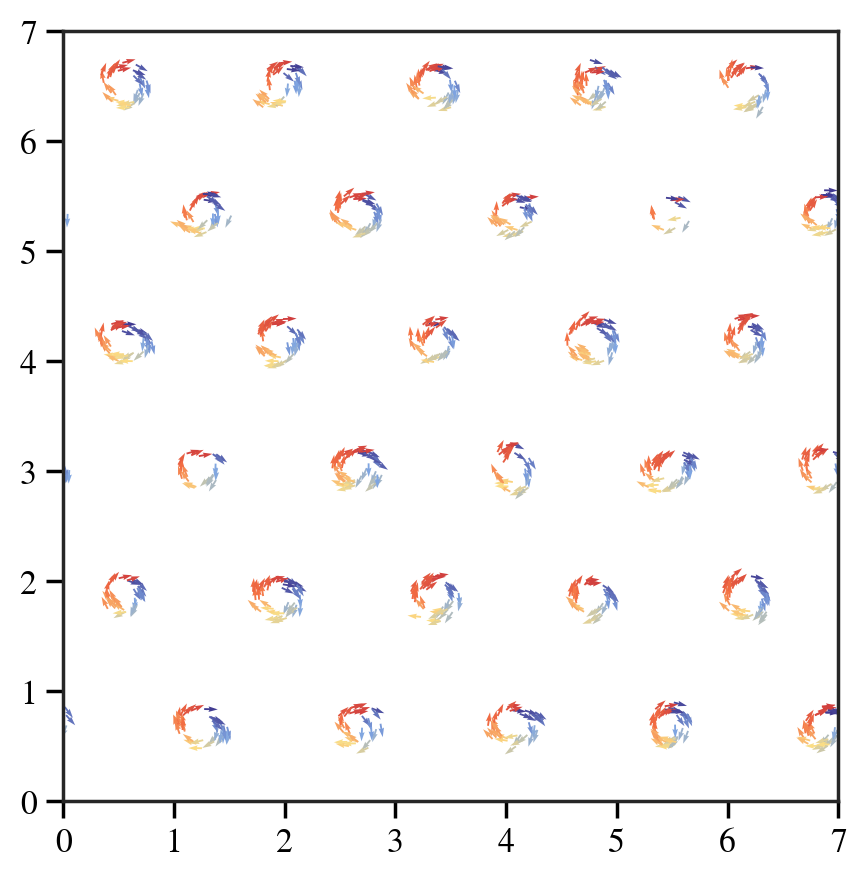

In [2]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    omegaMin=0, deltaOmega=0,
    dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=9, overWrite=True
)
sa = StateAnalysis(model)
sa.plot_spatial(colorsBy="phase")

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
tailDotPhaseThetas = np.array([sa.calc_dot_theta(lookIdx=i) for i in np.arange(-1000, 0, 10)])
effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classCenters = np.array([centers[c].mean(axis=0) for c in classes])
periodicEdges, adjClassCenters = sa.calc_nearby_edges(edgeLenThres=1.5, classCenters=classCenters)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()
classMaxRadius = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean() if np.any(freqOmega >= 0) else 0
    meanNegFreq = freqOmega[freqOmega < 0].mean() if np.any(freqOmega < 0) else 0

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()

    maxRadius = sa.calc_replative_distance(sa.totalPositionX[-1000:, oscIdx], 
                                           classCenters[classIdx]).max()
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)
    classMaxRadius.append(maxRadius)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

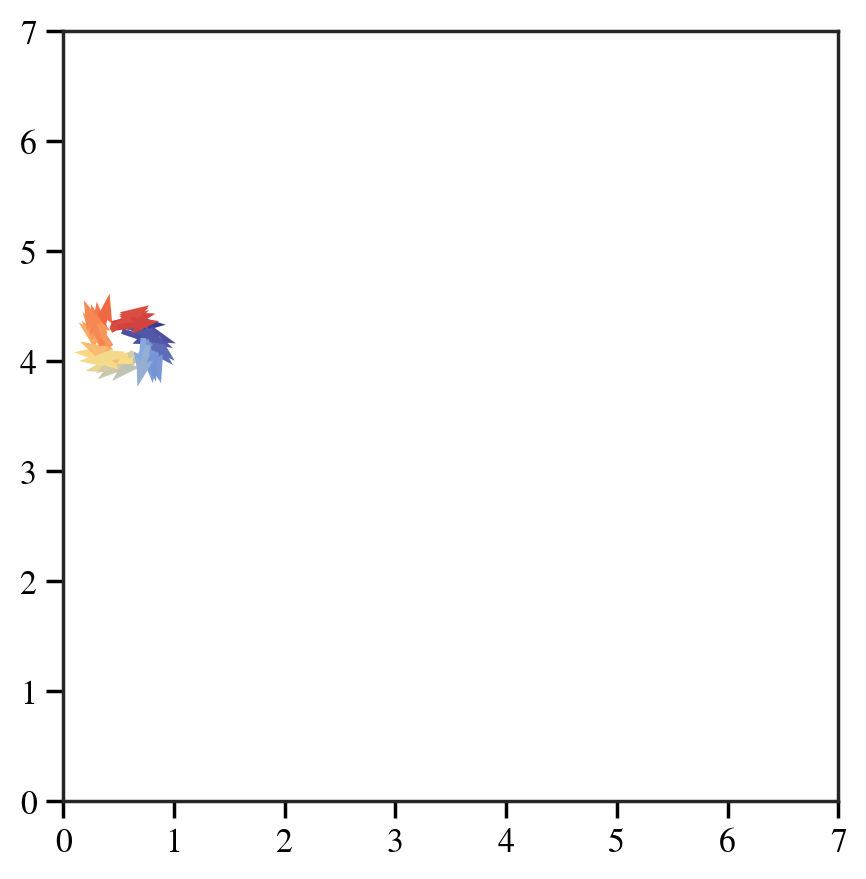

In [16]:
reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=len(classes[0]), dt=0.001,
    tqdm=True, savePath=None, shotsnaps=10, 
    randomSeed=9, overWrite=True
)

subIndexs = classes[0]

reduceModel.positionX = sa.totalPositionX[-1][subIndexs].copy()
reduceModel.phaseTheta = sa.totalPhaseTheta[-1][subIndexs].copy()
reduceModel.freqOmega = sa.model.freqOmega[subIndexs].copy()
reduceModel.plot(colorsBy="phase")

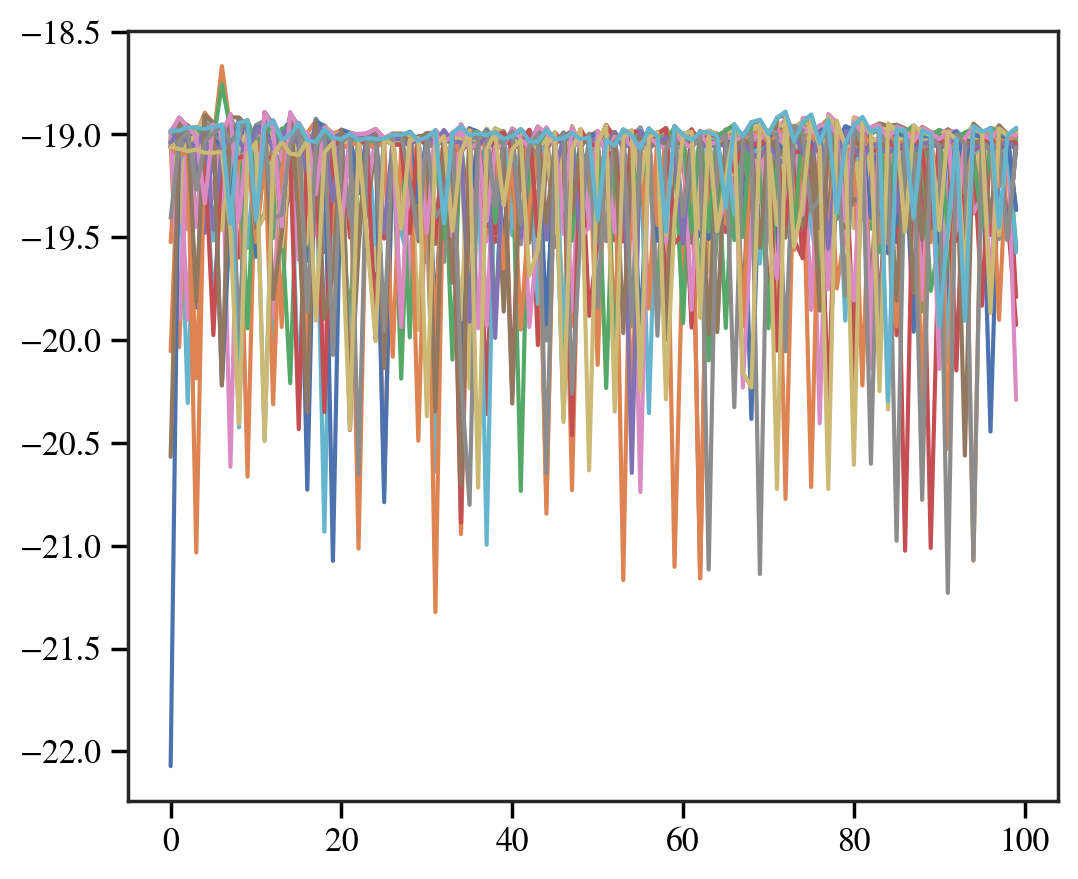

In [12]:
plt.plot(tailDotPhaseThetas[:, subIndexs])

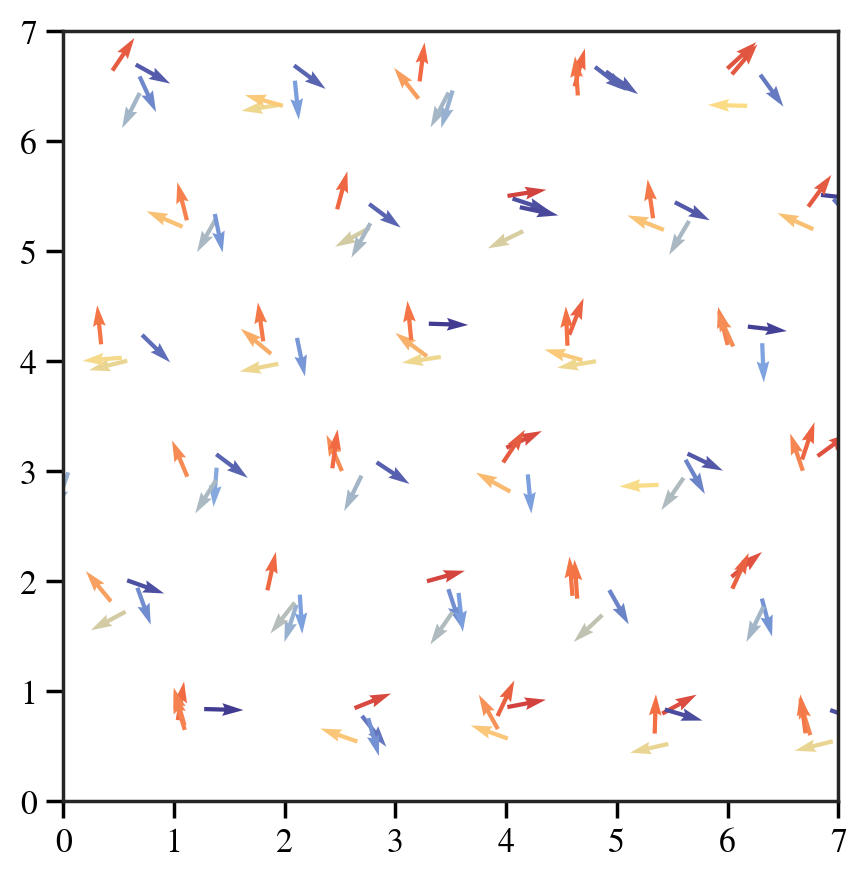

In [25]:
frontCounts = 4

reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=len(classes) * frontCounts, dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=9, overWrite=True
)

subIndexs = np.concatenate([c[:frontCounts] for c in classes])

reduceModel.positionX = sa.totalPositionX[-1][subIndexs].copy()
reduceModel.phaseTheta = sa.totalPhaseTheta[-1][subIndexs].copy()
reduceModel.freqOmega = sa.model.freqOmega[subIndexs].copy()
reduceModel.plot(colorsBy="phase")

In [17]:
reduceModel.run(1000000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

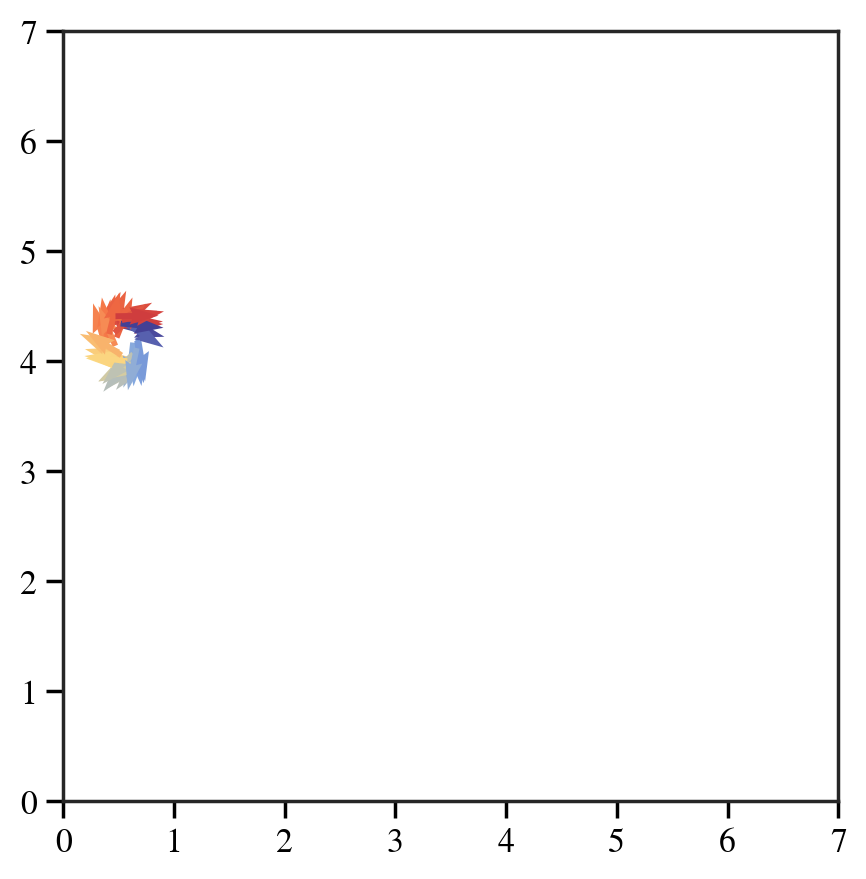

In [18]:
reduceModel.plot(colorsBy="phase")

In [ ]:
saR = StateAnalysis(reduceModel)

classes, centers = saR.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
tailDotPhaseThetas = np.array([saR.calc_dot_theta(lookIdx=i) for i in np.arange(-1000, 0, 10)])
effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classCenters = np.array([centers[c].mean(axis=0) for c in classes])
periodicEdges, adjClassCenters = saR.calc_nearby_edges(edgeLenThres=1.5, classCenters=classCenters)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()
classMaxRadius = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = saR.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean() if np.any(freqOmega >= 0) else 0
    meanNegFreq = freqOmega[freqOmega < 0].mean() if np.any(freqOmega < 0) else 0

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()

    maxRadius = saR.calc_replative_distance(saR.totalPositionX[-1000:, oscIdx], 
                                           classCenters[classIdx]).max()
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)
    classMaxRadius.append(maxRadius)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

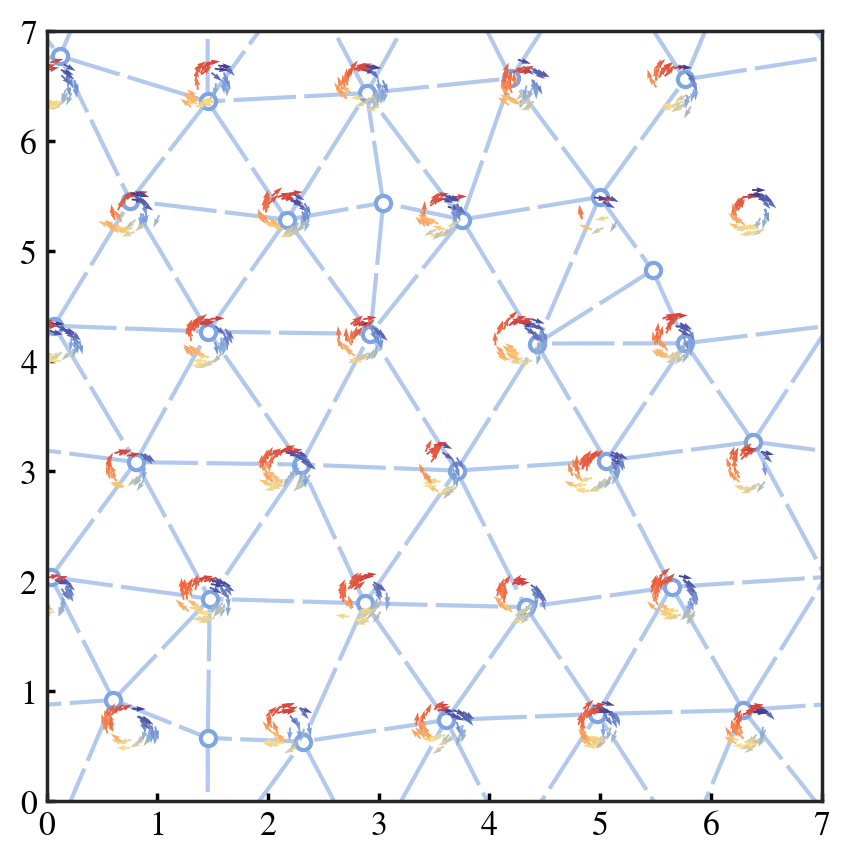

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

for edge in periodicEdges[:]:
    plt.plot(adjClassCenters[edge, 0], adjClassCenters[edge, 1], 
             color="#80A6E2", lw=1.5, alpha=0.6, linestyle=(0, (15, 2)), zorder=0)
plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    facecolor="white", cmap=cmap, s=30, edgecolor="#80A6E2", lw=1.5
)

sa.plot_spatial(ax=ax, colorsBy="phase")

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")

In [7]:
model = PurePhaseFrustration(strengthK=20, phaseLagA0=0.8 * np.pi, 
                             omegaMin=0, deltaOmega=0,
                             tqdm=True, savePath=SAVE_PATH, overWrite=True, shotsnaps=5)
model.run(30000)

  0%|          | 0/30000 [00:00<?, ?it/s]

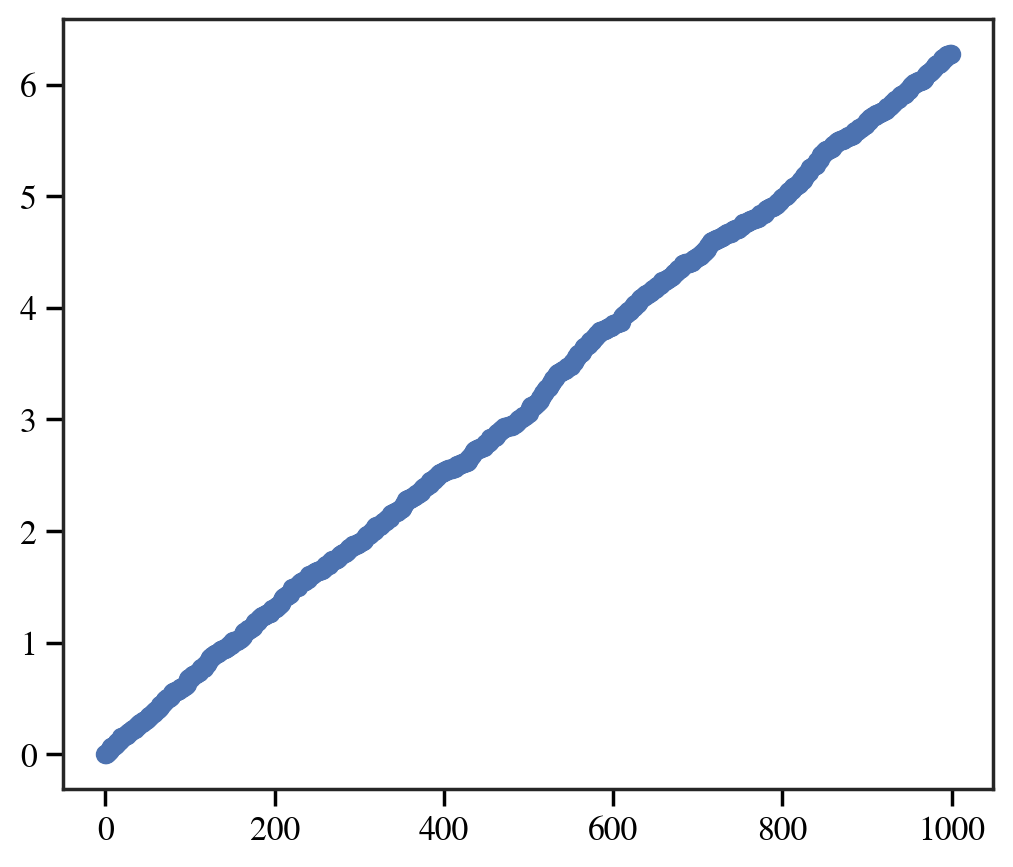

In [10]:
plt.scatter(np.arange(0, model.agentsNum), np.sort(model.phaseTheta))

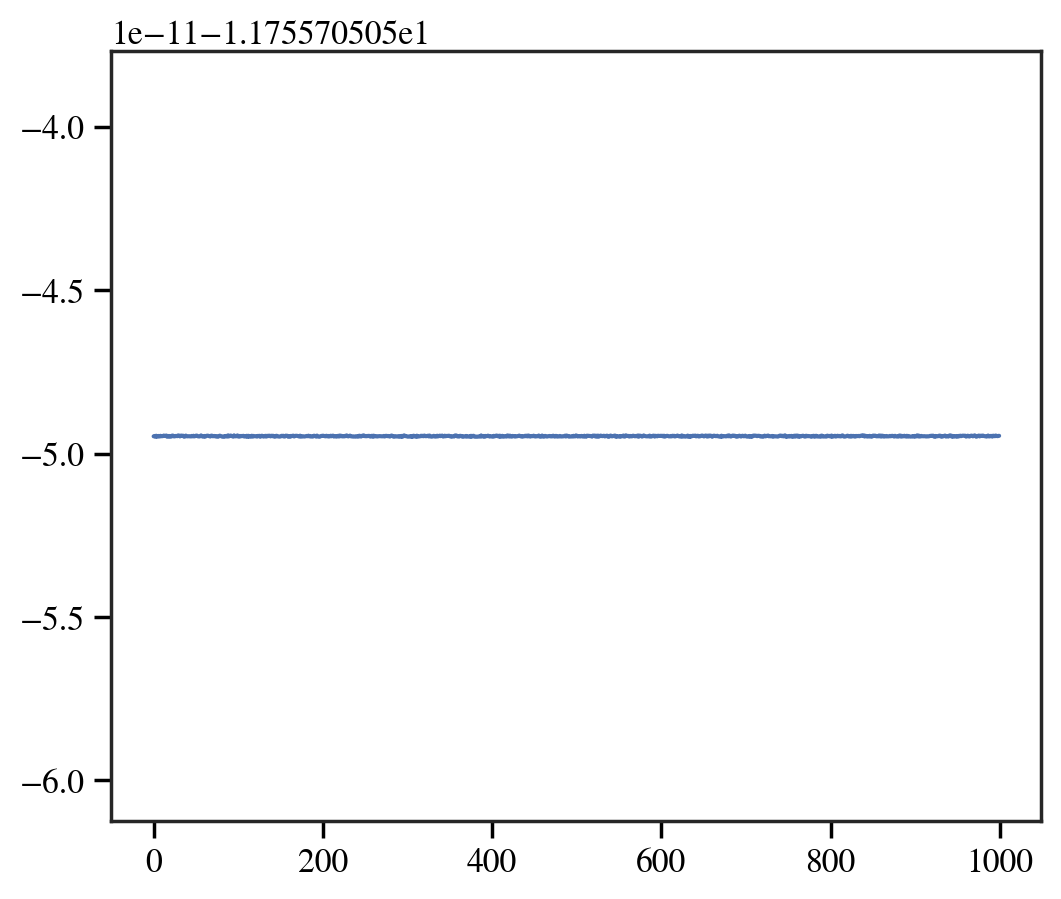

In [11]:
plt.plot(model.dotPhase)

In [8]:
-model.strengthK * np.sin(model.phaseLagA0)

-19.021130325903073

In [7]:
model.dotPhase

array([-19.76673569, -19.71921869, -19.66765551, -18.16102565,
       -18.72324412, -19.87894704, -19.72018802, -18.63225354,
       -18.15883855, -18.18080457, -19.88201285, -19.72675017,
       -18.64108386, -19.84231596, -19.76211934, -18.5422675 ,
       -19.38340843, -19.88260514, -18.44196003, -18.41883221,
       -19.37827565, -19.87108422, -18.6098896 , -18.34414578,
       -18.27403265, -18.34801658, -18.41676889, -18.23720844,
       -18.23849598, -18.76206044, -18.64843915, -19.86730941,
       -18.90863206, -18.75259962, -19.28304339, -18.79938401,
       -18.8124195 , -18.607792  , -18.5573807 , -18.23935041,
       -19.78216378, -18.20468456, -19.87984324, -19.22633373,
       -18.83224744, -18.15888431, -19.83815495, -19.39022674,
       -18.49798913, -19.71298293, -19.03043257, -18.89213724,
       -18.21214197, -19.88344746, -18.59912969, -19.86939419,
       -18.81832198, -18.18905007, -19.56596404, -18.3830177 ,
       -18.15964903, -19.45963353, -18.26079155, -19.37

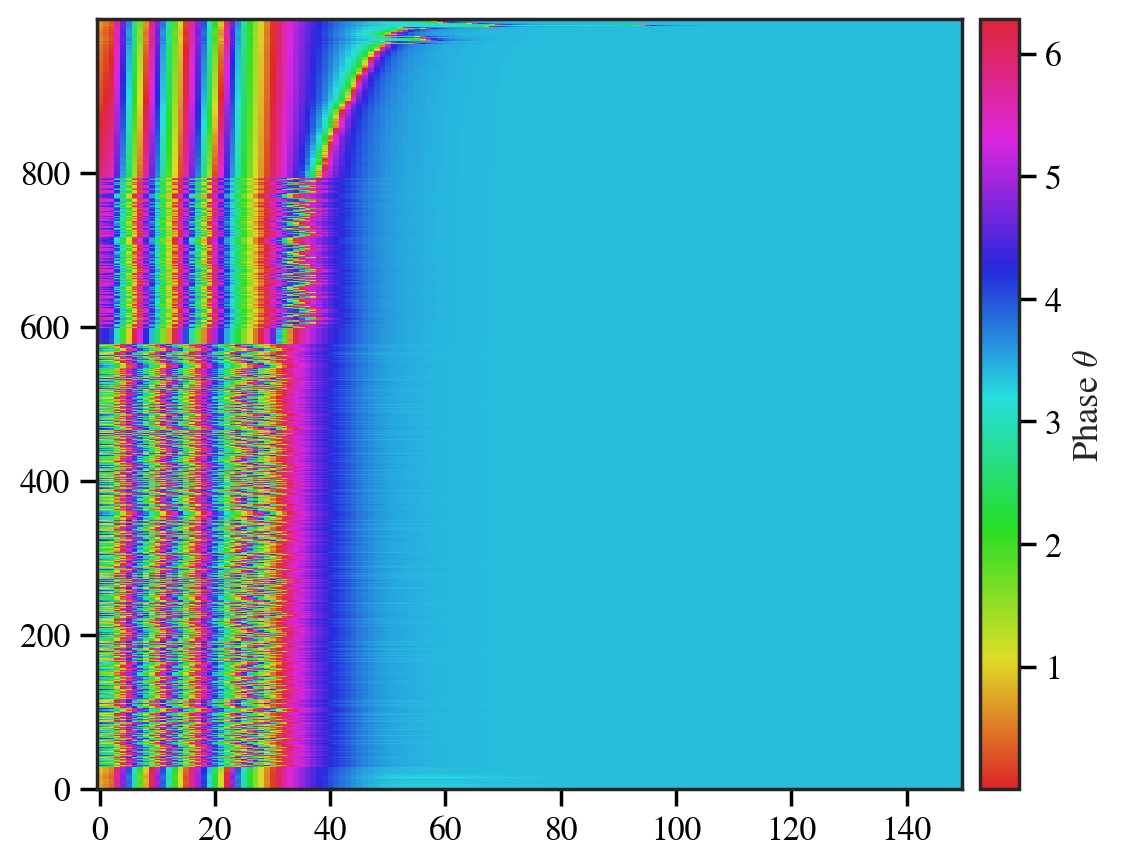

In [6]:
sa = StateAnalysis(model)
sortIdx = np.argsort(sa.totalPhaseTheta[-1])

# plt.figure(figsize=(10, 5))
plt.imshow(sa.totalPhaseTheta[:150, sortIdx].T, cmap=new_cmap, 
           origin="lower", aspect="auto", interpolation="none")
plt.colorbar(label=r"Phase $\theta$", fraction=0.05, pad=0.02)

In [2]:
strengthKs = np.linspace(1, 20, 10)
models = [
    PurePhaseFrustration(strengthK=strengthK, phaseLagA0=0.6 * np.pi, 
                            omegaMin=0, deltaOmega=0,
                            tqdm=True, savePath=SAVE_PATH, overWrite=True, shotsnaps=5)
    for strengthK in strengthKs
]
sas = [StateAnalysis(model) for model in tqdm(models)]

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
Rs = [np.abs(np.mean(np.exp(1j * sa.totalPhaseTheta[-1]))) for sa in sas]

(0.0, 1.0)

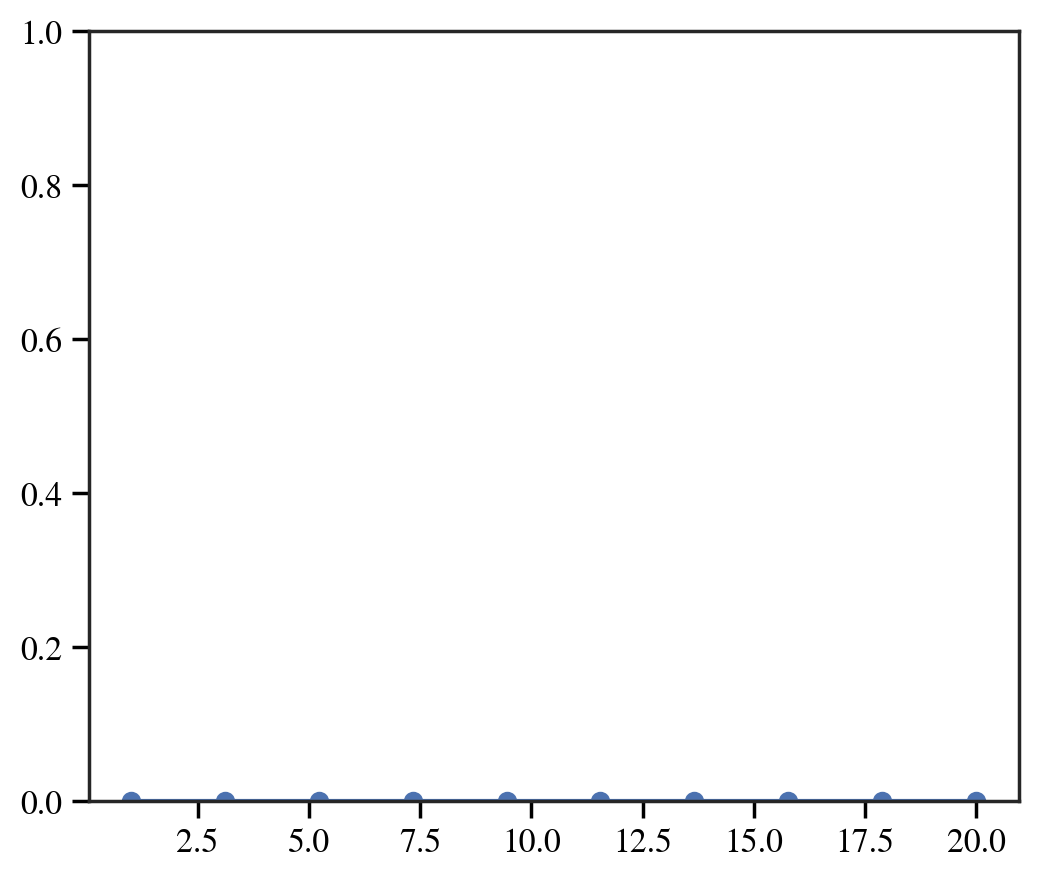

In [7]:
plt.plot(strengthKs, Rs, marker="o", lw=1.5)
plt.ylim(0, 1)

In [2]:
phaseLags = np.linspace(0, 1, 11) * np.pi
# phaseLags = [0.6 * np.pi]
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10
strengthKs = [20]  # np.linspace(1, 20, 7)
distanceD0s = [1]  # np.linspace(0.1, 3, 7)
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", 
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=1000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=True
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

sas = [StateAnalysis(model) for model in tqdm(models)]

  0%|          | 0/11 [00:00<?, ?it/s]

In [3]:
sa = sas[-3]

In [ ]:
sa.model.phaseLagA0

0.8